In [1]:
# Task 1: Import libraries
import pennylane as qml
from pennylane import numpy as np

Create a function that generates the Quantum Fourier Transform of a number $m$ via a quantum circuit with $n$-qubits
- Arguments:
  - `n`: The number of qubits in the variational quantum circuit
  - `m`: The number used to train the variational quantum circuit. Its values ranges from $0$ to $2^n - 1$
  - `steps`: The number of iterations during the optimization process
  - `learning_rate`: The step size of the optimizer; its default value should be set to 0.01
- Return values:
  - `circuit`: The variational quantum circuit comprizing $n$ qubits
  - `param_arr`: Consists of the parameter values after each optimization step
    - Shape = `(steps, n)`
  - `cost_arr`: Consists of the cost value of the circuit after each optimization step
    - Size = `n`
  - `cost`: The cost function
  
📝Notes:
- The angles of rotation of the $R_z$ gates are the parameters to be optimzied
- For tasks 3-6,
  - Apply a Hadamard gate to all qubits
  - Apply a $R_z$ gate to all qubits
  - The inverse QFT is applied to `wires` to evaluate the error in the quantum circuit
    - The QFT is a unitary matrix, so its inverse is equal to its adjoint
  - Task 5: Modify the `circuit()` f unction so that you can add a quantum measurement as the return value
    - This measurement should evaluate the probability distribution of the qubits' states
  - Task 6: Create a function wrapper, or `model` around the `circuit()` function with the quantum device using `dev` as the argument
- Task 7: Create the cost function that evaluates the error value of the actual state
  - The ultimate goal of the quantum circuit is to retrieve the quantum state corresponding to `m`.

🔰 Review: The Cost Function
- Recall the formula for the mean square error
$$MSE = \sum_{i}{(y_i-y_i')^2}$$
  - $y_i=$ the $i^\text{th}$ element of the cost array
  - $y_i'=$ the $i^\text{th}$ element of the predicted array
    - For this project, `y` wil be `y[m]=1` and `y[i]=0` $\forall \ i\neq m$.

In [2]:
def qft_via_qml(n: int, m: int, steps: int, learning_rate = 0.01):
    # Task 2: Load a Quantum Device
    dev = qml.device('default.qubit', wires = n)
    # Task 3-6: Create the Quantum Circuit
    @qml.qnode(dev)
    def circuit(theta) -> float:
        for i in range(n):
            qml.Hadamard(wires = i)
            qml.RZ(theta[i], wires=i)
        qml.adjoint(qml.QFT)(wires=range(n))    # apply the inverse QFT matrix
        return qml.probs(wires=range(n))        # probability distribution of qubit states
    # Task 7: Create the Cost Function
    def cost(params) -> float:
        y = np.zeros(2**n)
        y[m] = 1
        probs = circuit(params)
        return np.sum(np.square((y-probs)))    
    # Task 8: Initialize the Optimizer
    opt = qml.RMSPropOptimizer(stepsize=learning_rate)
    # Task 9: Construct the Optimization Block
    # Set the initial value of the parameter
    params = np.zeros(n)
    param_arr = np.empty([steps, n])
    cost_arr = np.empty(steps)
    # Optimization
    for i in range(steps):
        params = opt.step(cost, params)
        param_arr[i] = params
        cost_arr[i] = cost(params)
    # Print the results
    print("Optimized rotation angles: ", params)
    print("Cost value at optimized parameters: ", cost(params))
    
    return circuit, param_arr, cost_arr, cost

In [3]:
# Task 10: Test the Optimizer
circuit, param_arr, cost_arr, cost = qft_via_qml(2, 3, 500)

Optimized rotation angles:  [0. 0.]
Cost value at optimized parameters:  1.9999999999999991


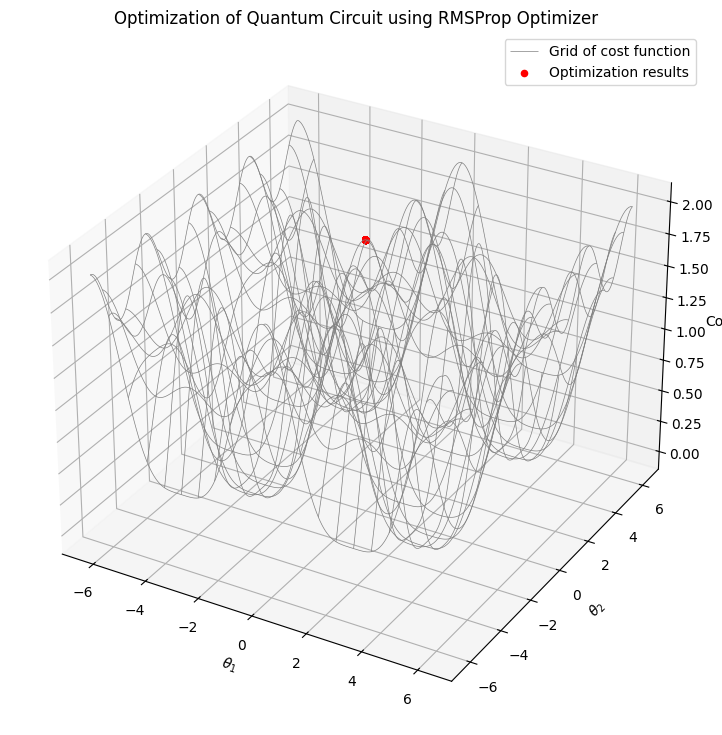

In [4]:
# Task 11: Visualize the Optimization Process
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from surface_plot import plot_opt_surface
plot_opt_surface(cost_arr, param_arr, 3, cost)